In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools

### Exercise 1

In [ ]:
def generate_W(N):
    upper_tri = np.triu(np.random.uniform(-1,1,N**2).reshape((N,N)))  # fill upper triangle with uniformly distrib. random values [-1, 1]
    W = upper_tri + upper_tri.T  # mirror to fill lower triangle
    np.fill_diagonal(W, 0)  # set diagonal (self-connections) to zero
    check_W(W)
    return W


def check_W(W):
    assert np.allclose(W, W.T)  # check symmetrie of matrix
    assert np.allclose(np.diag(W), np.zeros((W.shape[0], )))  # check diagonal entries, W is quadratic


def random_s(N):
    s = np.random.binomial(1,0.5,N)
    for i,state in enumerate(s):
        if state==0:
            s[i]=-1
    return s


def energy(s,W):
    E = 0
    for s_i in s:
        E += s_i * np.sum(W @ s)  # this corresponds to j-loop for fix i

    E *= -0.5
    return E


def energy_options(s,i,W):
    s_i = s[i]
    E = 0
    for j in range(0,len(s)):
        if j!=i:  # actually not necessary, because w[i][j=i] = 0
            E += s_i * W[i][j]*s[j]  # this corresponds to j-loop for fix i
    return E   # the -2 * (-1/2) cancels for the delta_E


def prob_annealing(beta,energy_inc):
    P = (1+np.exp(beta*energy_inc))**-1 
    return P

In [ ]:
N = 6  # number of nodes

### A) Initialization

In [ ]:
W = generate_W(N)
s0 = random_s(N)

In [ ]:
def annealing(s0,N,W,M,iterations,beta0,tau):
    s = 0
    s = np.vstack((s0,np.zeros((iterations-1,N))))
    beta = 0
    beta = np.append(beta0,np.zeros(iterations-1))  
    energy_tot = 0
    energy_tot = np.append(energy(s[0,:],W),np.zeros(iterations-1))

    for i in range(1,iterations):
        for j in range(0,M):
            ind = np.random.randint(0,N)  # select one of the nodes randomly
            energy_inc = energy_options(s[i-1,:],ind,W)
            P = prob_annealing(beta[i-1],energy_inc)
            s[i,:] = decision(P,s[i-1,:],ind)
            # print(energy_inc)
        beta[i] = beta[i-1]*tau
        energy_tot[i] = energy(s[i,:],W)

    return s,energy_tot,beta
           
def decision(prob,s,i):
    change = random.random() < prob
    if change:
        s[i] = -s[i]

    return s

### C) Visualization.

In [ ]:
def all_states(N):
    lst = list(itertools.product([-1, 1], repeat=N))  
    return lst

all_combs = all_states(6)

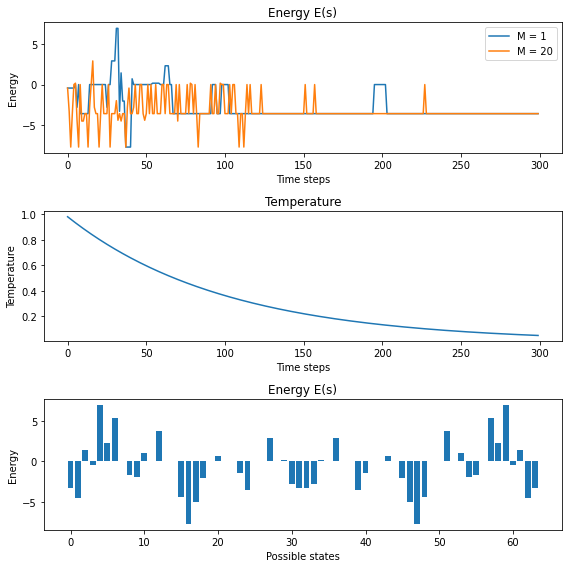

In [ ]:
M = np.array([1,20])
tmax = 300
beta0 = 1.02
tau = 1.01
time = np.arange(0,tmax)

fig, ax = plt.subplots(figsize=(8,8),nrows=3,ncols=1)

for i in range(0,len(M)):
    s,En,betas = annealing(s0,N,W,M[i],tmax,beta0,tau)
    ax[0].plot(time,En,label=f'M = {M[i]}')
    ax[0].legend()
    ax[0].set_title('Energy E(s)')
    ax[0].set_ylabel('Energy')
    ax[0].set_xlabel('Time steps')

ax[1].plot(time,1/betas)
ax[1].set_title('Temperature')
ax[1].set_ylabel('Temperature')
ax[1].set_xlabel('Time steps')

E = np.zeros(2**6)
for i in range(0,len(E)):
    E[i] = energy(all_combs[i],W)

ax[2].bar(np.arange(0,len(E)),E)
ax[2].set_title('Energy E(s)')
ax[2].set_xlabel('Possible states')
ax[2].set_ylabel('Energy')

plt.tight_layout();

We can observe that the temperature decays over time and that there are only higher energy states in the beginning. Not all possible states have the same energy. For bigger M states tend to switch quicker, in any case discrete energy-states can be observed.

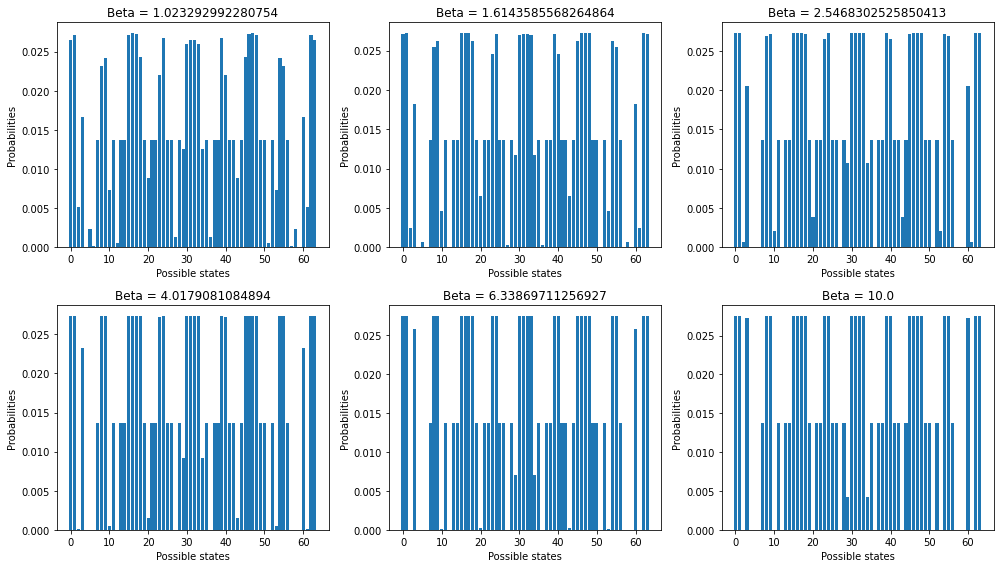

In [ ]:
fig, ax = plt.subplots(figsize=(14,8),nrows=2,ncols=3)
betas = np.logspace (0.01,1,num=6)

num = 0
for i in range(0,2):
    for j in range(0,3):
        beta = betas[num]
        prob = np.zeros(2**6)
        for k in range(0,len(prob)):
            prob[k] = (1+np.exp(beta*E[k]))**-1
        
        prob = prob/np.sum(prob)
        
        ax[i][j].bar(np.arange(0,len(prob)),prob)
        ax[i][j].set_title(f'Beta = {beta}')
        ax[i][j].set_xlabel('Possible states')
        ax[i][j].set_ylabel('Probabilities')

         
        num += 1

plt.tight_layout()

With higher beta less states have a non-zero energy and the energies are distributed to less levels.

## Exercise 2.

In [ ]:
# TODO: Finish function, create additional plots
# > the results look not as we'd expect tried to track down the issue but couldn't resolve it.

def update_moment(ek, beta):
    return np.tanh(-beta*ek)

def mean_field(w, s, k):
    return - w[:,k] @ s  

def mean_field_annealing(s0,N,W,iterations,beta0,tau,epsilon):
    s = np.array(s0, dtype=float)  # otherwise rounding issue when computing tanh bc. initialized as int
    e = np.zeros(s.shape)
    beta = beta0
    beta = np.append(beta0, np.zeros(iterations-1))  

    s_array = np.zeros((iterations, N))
    s_array[0] = s

    energies = np.append(energy(s, W), np.zeros(iterations-1))
    c_tots = []  # keeping track of iterations till convergence for tracking issue
    for i in range(1,iterations):
        e_check = epsilon*10  # just set high so while-loop is entered
        c_tot = 0  # reset
        s_old = s.copy()
        while e_check>epsilon:
            c_tot +=1
            e_old = e.copy()  # update 

            for k in range(N):
 
                e[k] = mean_field(W, s, k)
                s[k] = update_moment(e[k], beta[i-1])
                
                # cross-check with the approach that Group 'ALT' used in their assignment.
                assert np.isclose(s[k], np.tanh(-beta[i-1] * e[k]))  # first moment-update
                assert np.isclose(e[k], -np.sum([W[j,k]*s[j] for j in range(N) if not j==k]))  # mf-computation

            e_check = np.linalg.norm(e-e_old)  # euclidean distance
 
        energies[i] = energy(s,W)

        beta[i] = beta[i-1]*tau
        s_array[i] = s

        c_tots.append(c_tot)  # issue tracking...

    return energies, beta, c_tots

In [ ]:
tmax = 300
beta0 = 1.02
tau = 1.01
s0 = random_s(N)
epsilon = 0.00005

energies, betas, c_tots = mean_field_annealing(s0, N, W, tmax, beta0, tau, epsilon)

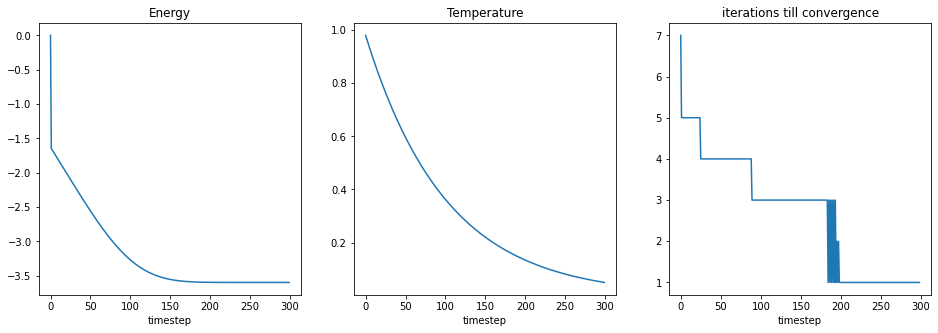

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(16,5))
axs[0].plot(energies)
axs[0].set_title('Energy')
axs[0].set_xlabel('timestep')
axs[1].plot(1/betas)
axs[1].set_xlabel('timestep')
axs[1].set_title('Temperature')
axs[2].plot(c_tots)
axs[2].set_xlabel('timestep')
axs[2].set_title('iterations till convergence');

We re-run our code a few times and mostly observed a very weird behaviour of the energy where there was basically an up-and-down oscillation in it. We tried to track down the issue: the group 'ALT' was so nice to share their results so we could us cross-check and because of that we added the assertions in the code above. However, it seems that the problem is neither caused by our updating nor mean-field computation. 